In [31]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from surya.foundation import FoundationPredictor
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor
import torch
from pdf2image import convert_from_path
import os
import io
import gc
from PIL import Image

In [32]:
!pip install pdf2image 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [33]:
from surya.foundation import FoundationPredictor
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor
import torch
import torch
import os
from tqdm import tqdm
import numpy as np
import  cv2
device = "mps" if torch.backends.mps.is_available() else "cpu"
def pdf_to_images(path, dpi=300):
    images = []
    if os.path.isfile(path):
        images.extend(convert_from_path(path, dpi=dpi))
    else:
        for pdf_file in tqdm(os.listdir(path), desc="Converting PDFs"):
            if pdf_file.lower().endswith('.pdf'):
                pdf_path = os.path.join(path, pdf_file)
                images.extend(convert_from_path(pdf_path, dpi=dpi))
    print(f"\n✅ Conversion complete!")
    return images

pages = pdf_to_images("/Users/maryamsaad/Documents/grad_data/fast_test.pdf")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



✅ Conversion complete!


In [36]:
len(pages)

4

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



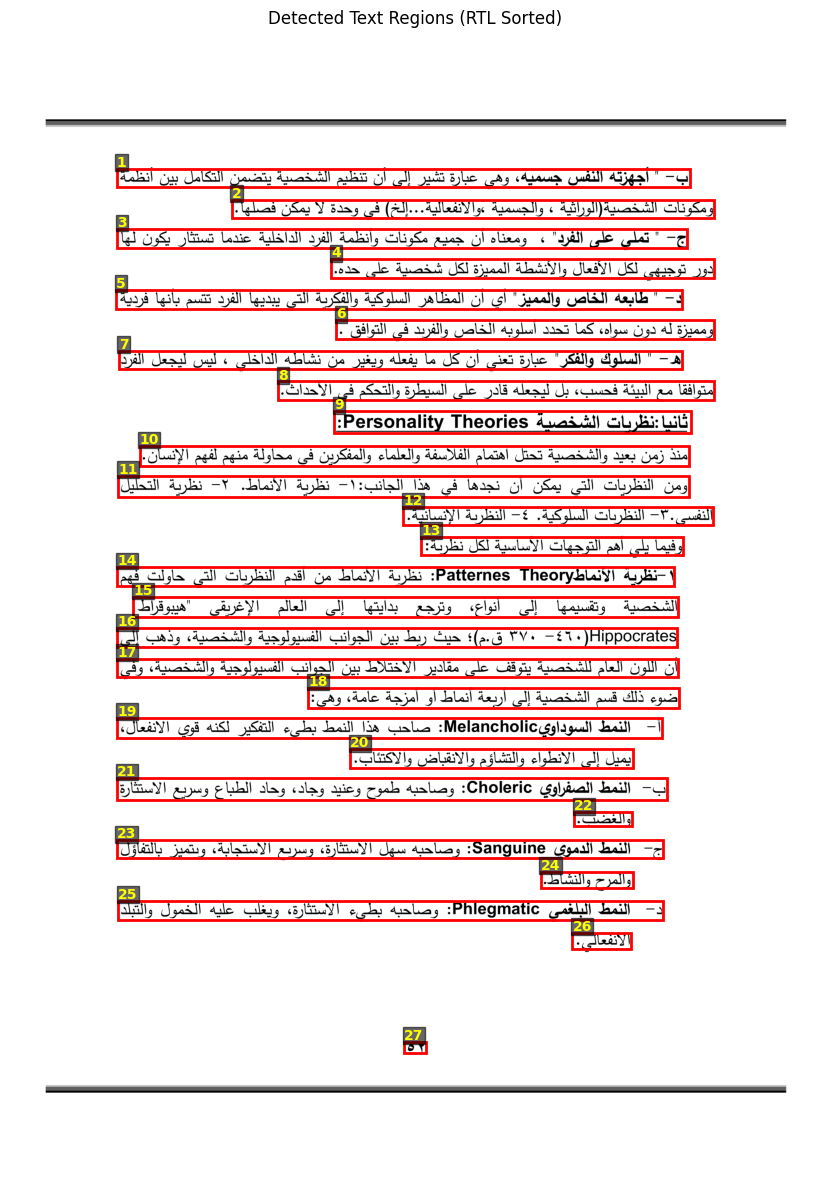

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]]



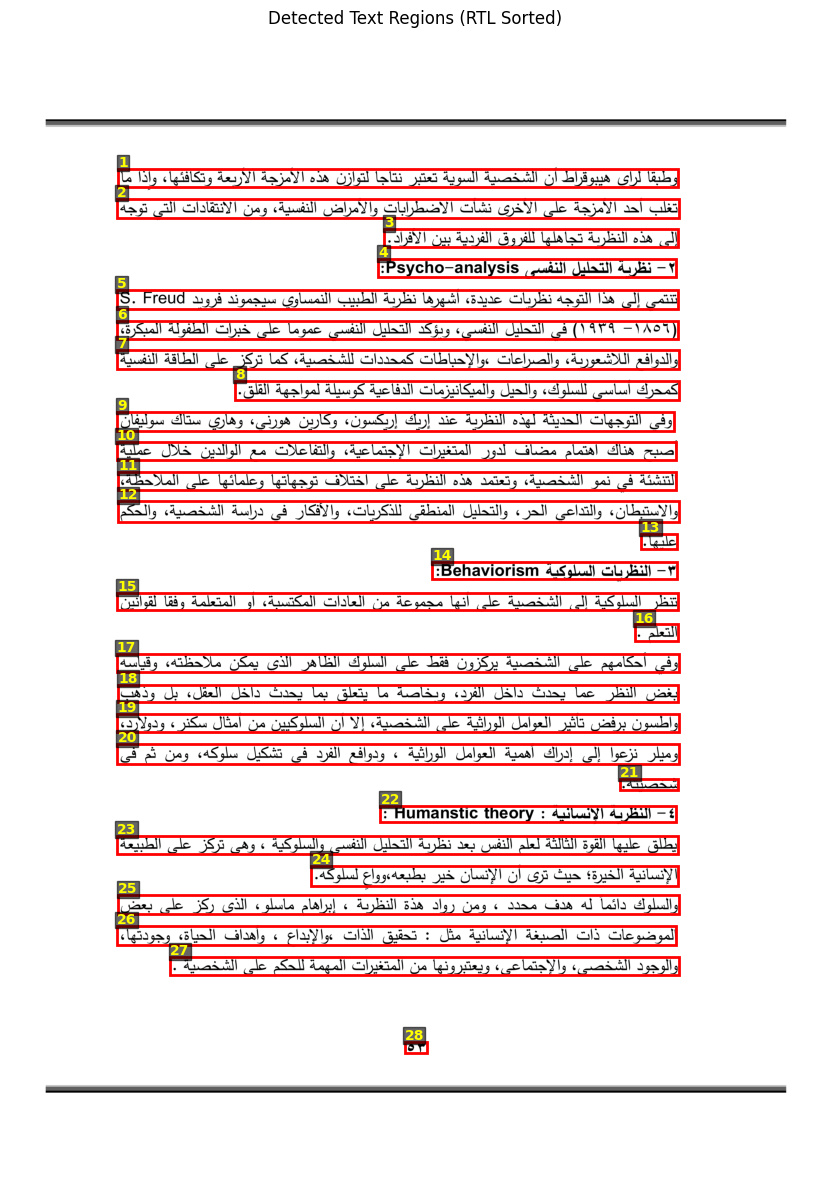

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]]



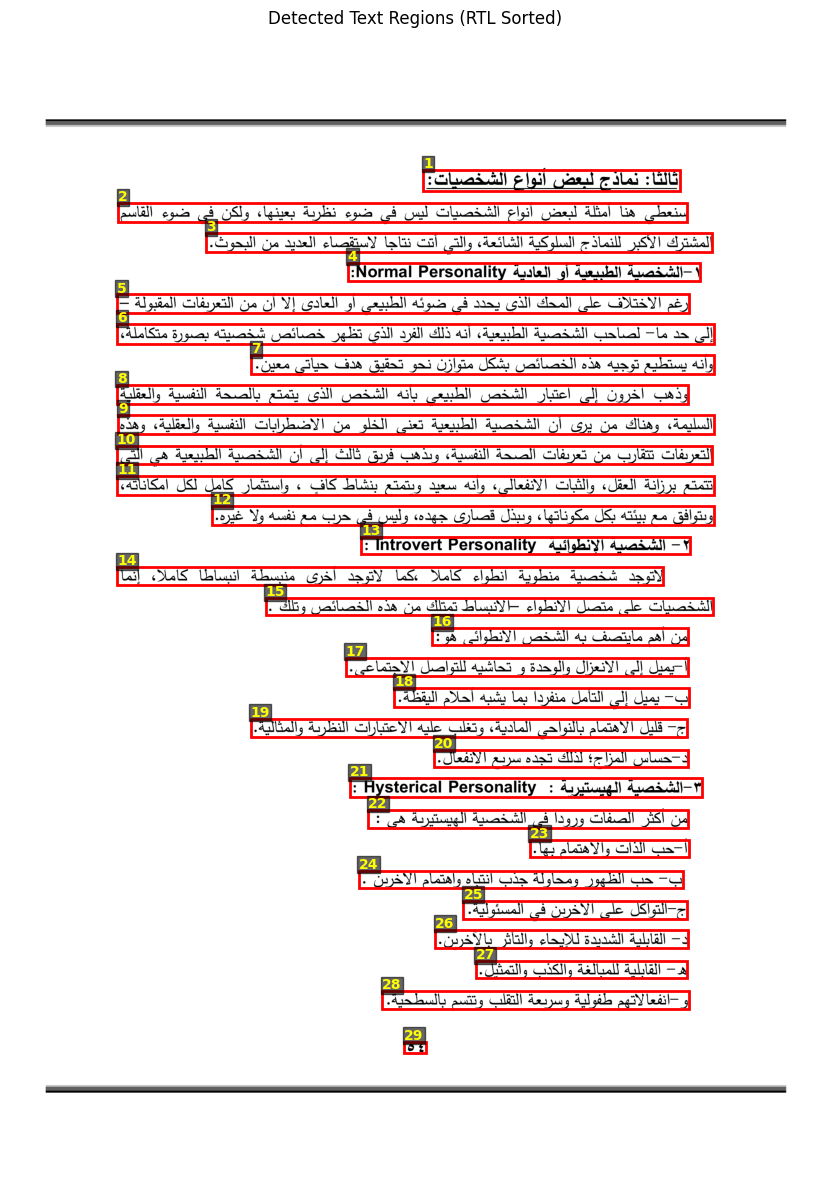

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]]



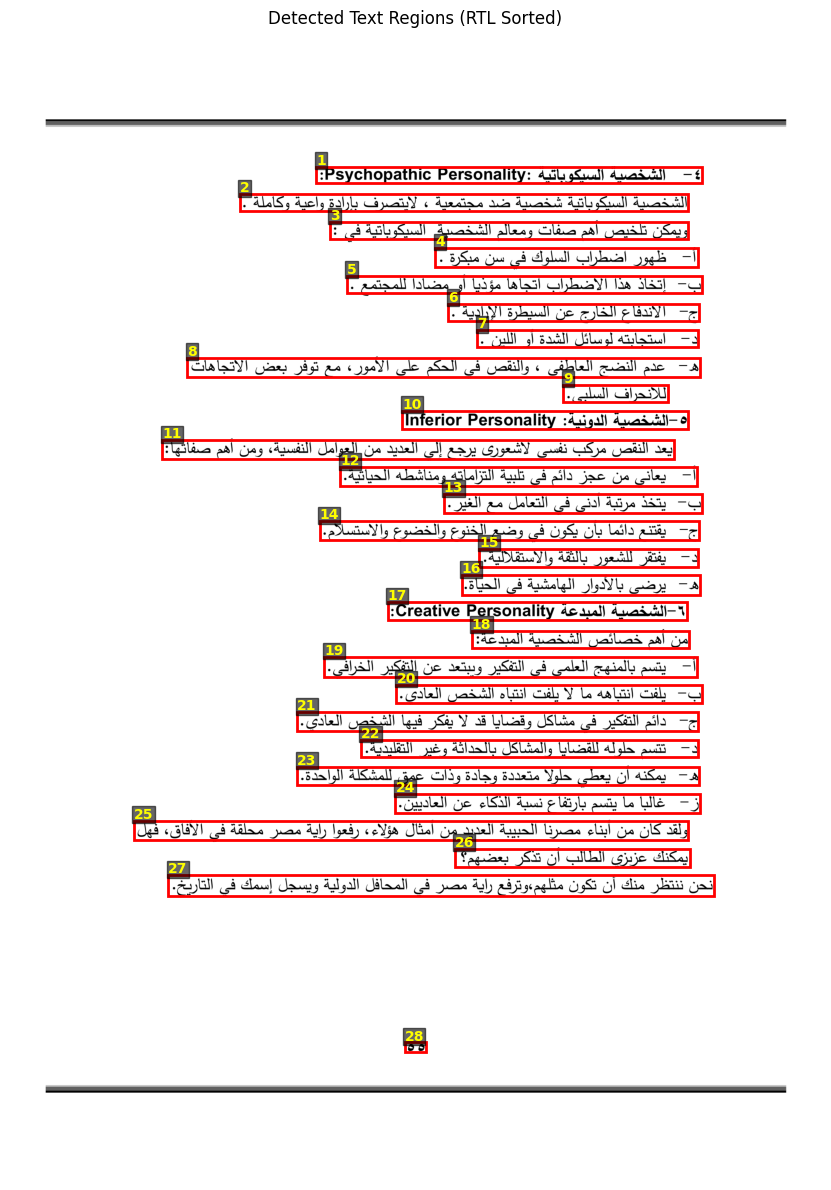

Processing Images: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


In [38]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Helper: Sort boxes for Arabic reading order (top→bottom, right→left) ---
def sort_bboxes_rtl(bboxes, y_threshold=20):
    """
    Sort bounding boxes top-to-bottom and right-to-left within each line.
    This helps visualize text in Arabic order for OCR or debugging.
    """
    if not bboxes:
        return []
    
    # Extract [x1, y1, x2, y2]
    boxes = [[b.bbox[0], b.bbox[1], b.bbox[2], b.bbox[3]] for b in bboxes]
    
    # Sort by top Y coordinate (line order)
    boxes = sorted(boxes, key=lambda b: b[1])

    # Group boxes into lines (based on vertical proximity)
    lines = []
    current_line = [boxes[0]]
    for b in boxes[1:]:
        if abs(b[1] - current_line[-1][1]) < y_threshold:
            current_line.append(b)
        else:
            lines.append(current_line)
            current_line = [b]
    lines.append(current_line)

    # Sort each line right-to-left
    sorted_boxes = []
    for line in lines:
        line_sorted = sorted(line, key=lambda b: b[0], reverse=True)
        sorted_boxes.extend(line_sorted)
    
    return sorted_boxes


# --- Detection + Visualization ---
foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.65

for image in tqdm(pages, desc="Processing Images"):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]

    # Filter by confidence
    filtered_boxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    # Sort RTL
    sorted_boxes = sort_bboxes_rtl(filtered_boxes)

    # --- Plot with bounding boxes ---
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)

    for i, (x1, y1, x2, y2) in enumerate(sorted_boxes, start=1):
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 6, f"{i}",
            color="yellow",
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.6, pad=1)
        )

    plt.title("Detected Text Regions (RTL Sorted)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


## initlizing ocr

In [39]:
import torch
from transformers import AutoProcessor,Qwen2VLForConditionalGeneration
from PIL import Image
from pdf2image import convert_from_path
from PIL import Image
import os
from tqdm import tqdm
import json
from jiwer import wer, cer, process_words
import re

In [40]:

model_id = "NAMAA-Space/Qari-OCR-v0.3-VL-2B-Instruct"
processor_id = "Qwen/Qwen2-VL-2B-Instruct"

# Use CPU for now (MPS has memory issues with large vision models)
device = torch.device("mps")
print(device)

# Load model with float32 for CPU
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16, 
    trust_remote_code=True,
    cache_dir="./Qari_model_cache"
).to(device)

# Load processor
processor = AutoProcessor.from_pretrained(
    processor_id,
    trust_remote_code=True,
    cache_dir="./Qwen_processor_cache"
)

print(f"✅ Model ready on {device}")


mps
✅ Model ready on mps
✅ Model ready on mps


In [41]:
def get_ocr_prompt() -> str:
    """Get the OCR instruction prompt for Arabic text."""
    return """
        You are an Arabic OCR specialist designed to extract text from images containing Arabic content. When processing images:
        1. ALWAYS read Arabic text from right to left, and top to bottom.
        3. DO NOT hallucinate text when encountering:
           - Decorative elements
           - Page numbers, stamps, or margin notes
           - Blurry or unclear text
        4. When text is unclear, mark it as [غير واضح].
        5. Only transcribe visible text — accuracy > completeness.
        6. Ignore watermarks and non-text background elements.
        8. Preserve original formatting, including line breaks and spacing.
        9. Do not hallucinate punctuation or diacritics. 
        10. Output the extracted text as it is visually presented in the image.
        Return the extracted text only.
    """


In [42]:
def extract_text_from_image(images, model, processor, max_size=(1024, 1024)):
    ocr_results = []

    for img in tqdm(images, desc="Extracting text"):
        # Resize image if too large
        if img.size[0] > max_size[0] or img.size[1] > max_size[1]:
            img.thumbnail(max_size, Image.Resampling.LANCZOS)
        
        prompt_messages = [
            {"role": "system", "content": get_ocr_prompt()},
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": img},
                    {"type": "text", "text": "Extract text from the provided image accurately."}
                ]
            }
        ]
        # Apply chat template
        prompt_text = processor.apply_chat_template(
            prompt_messages,
            add_generation_prompt=True,
            tokenize=False
        )

        # Tokenize with image input
        inputs = processor(
            text=prompt_text,
            images=img,
            return_tensors="pt",
            padding=True
        ).to(model.device)

        # Run inference with valid parameters only
        with torch.inference_mode():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=1500,
                do_sample=False, 
                repetition_penalty=1.4,
                # pad_token_id=processor.tokenizer.eos_token_id
            )
        

        generated_text = processor.batch_decode(
            generated_ids, 
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )[0]
        ocr_results.append(generated_text.strip())

    return ocr_results

## preparing text boxes to ocr

In [44]:
sorted_boxes

[[936, 410, 2114, 459],
 [702, 495, 2073, 546],
 [977, 579, 2072, 632],
 [1299, 659, 2102, 718],
 [1029, 744, 2114, 797],
 [1339, 829, 2105, 883],
 [1428, 911, 2103, 961],
 [541, 994, 2108, 1052],
 [1691, 1078, 2010, 1130],
 [1199, 1156, 2071, 1213],
 [465, 1247, 2029, 1303],
 [1010, 1329, 2099, 1386],
 [1326, 1412, 2114, 1470],
 [946, 1495, 2105, 1552],
 [1434, 1579, 2103, 1634],
 [1380, 1660, 2110, 1721],
 [1154, 1741, 2069, 1797],
 [1411, 1829, 2077, 1883],
 [960, 1909, 2100, 1971],
 [1181, 1995, 2114, 2051],
 [878, 2078, 2103, 2135],
 [1072, 2163, 2103, 2216],
 [878, 2245, 2105, 2302],
 [1178, 2329, 2110, 2385],
 [378, 2410, 2074, 2468],
 [1359, 2495, 2079, 2551],
 [483, 2577, 2151, 2639],
 [1206, 3088, 1271, 3116]]

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



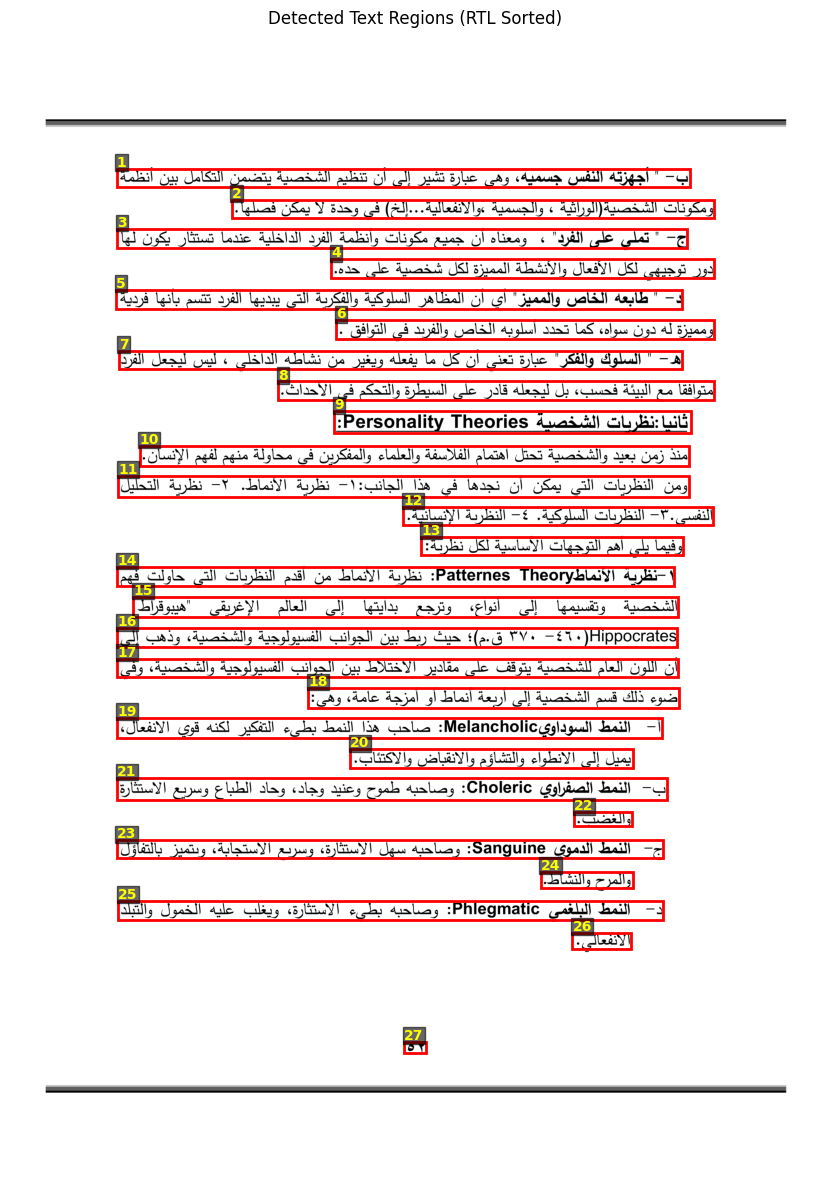

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]]



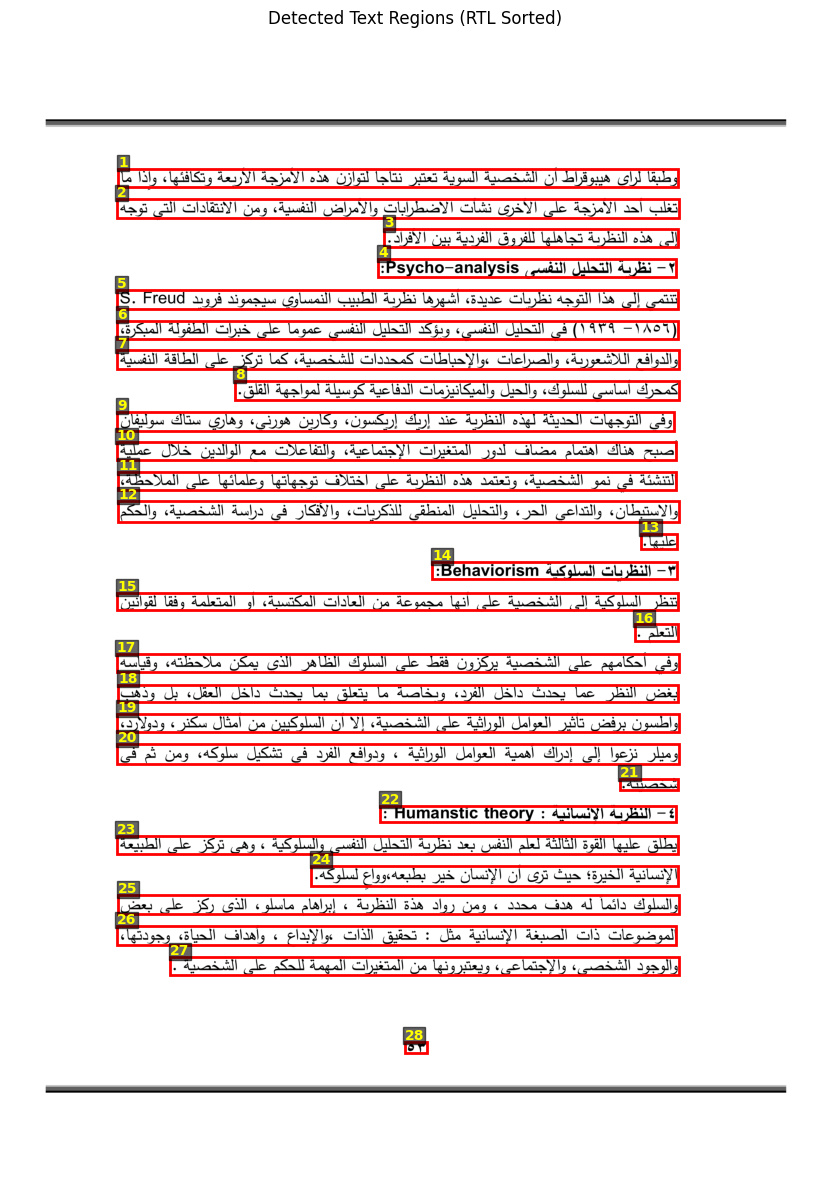

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]]



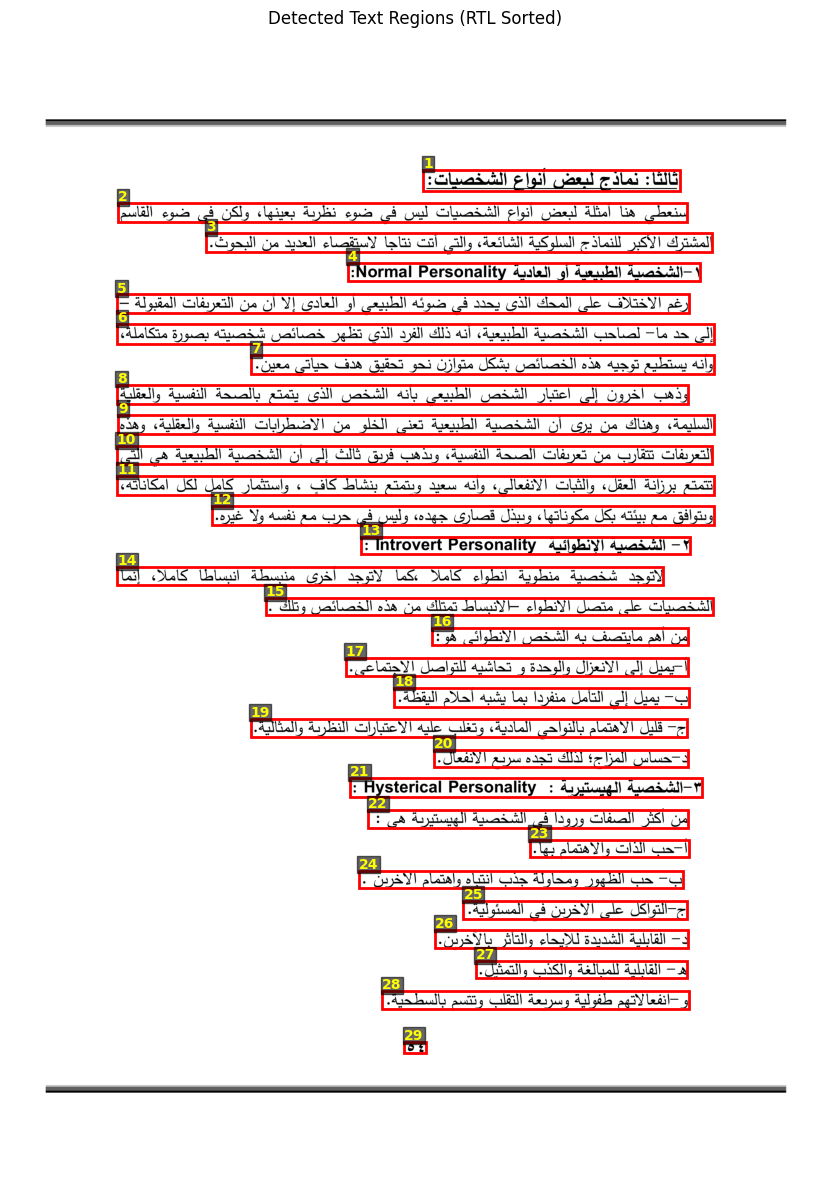

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]]



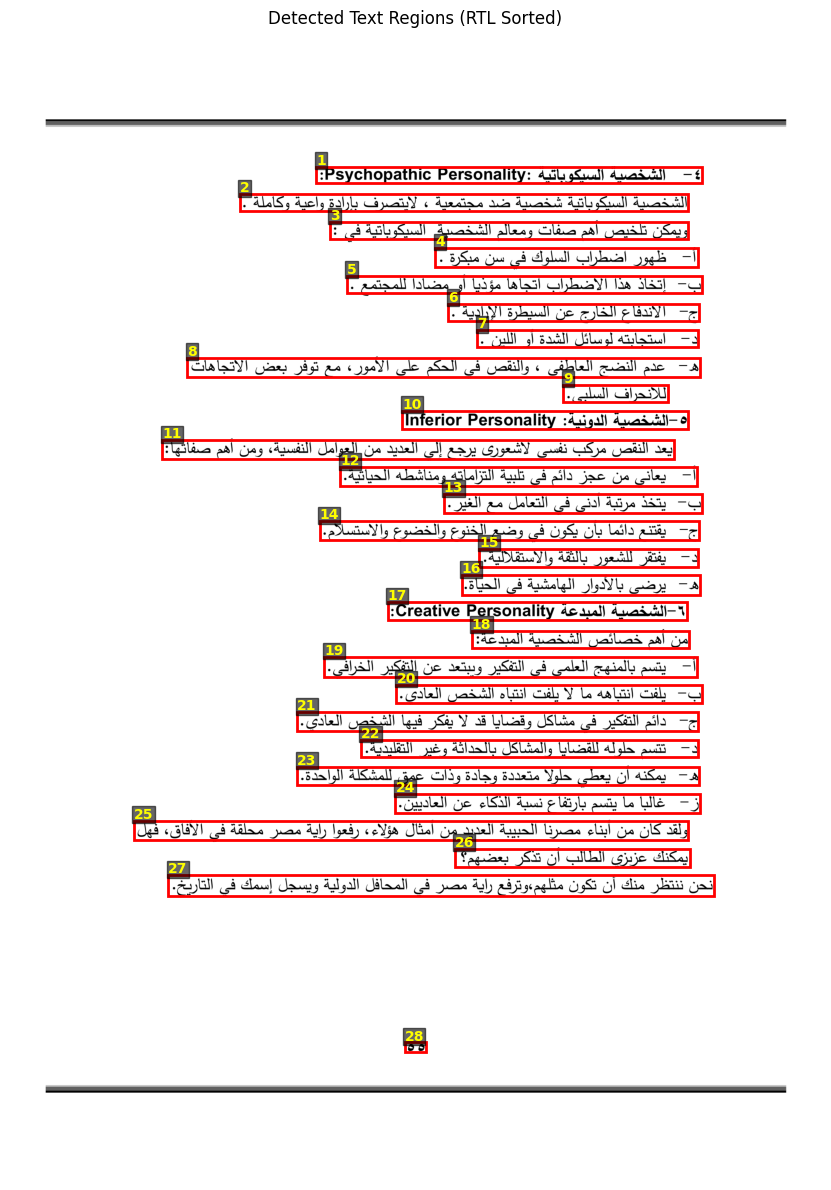

Processing Images: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


In [45]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Helper: Sort boxes for Arabic reading order (top→bottom, right→left) ---
def sort_bboxes_rtl(bboxes, y_threshold=20):
    """
    Sort bounding boxes top-to-bottom and right-to-left within each line.
    This helps visualize text in Arabic order for OCR or debugging.
    """
    if not bboxes:
        return []
    
    # Extract [x1, y1, x2, y2]
    boxes = [[b.bbox[0], b.bbox[1], b.bbox[2], b.bbox[3]] for b in bboxes]
    
    # Sort by top Y coordinate (line order)
    boxes = sorted(boxes, key=lambda b: b[1])

    # Group boxes into lines (based on vertical proximity)
    lines = []
    current_line = [boxes[0]]
    for b in boxes[1:]:
        if abs(b[1] - current_line[-1][1]) < y_threshold:
            current_line.append(b)
        else:
            lines.append(current_line)
            current_line = [b]
    lines.append(current_line)

    # Sort each line right-to-left
    sorted_boxes = []
    for line in lines:
        line_sorted = sorted(line, key=lambda b: b[0], reverse=True)
        sorted_boxes.extend(line_sorted)
    
    return sorted_boxes


# --- Detection + Visualization ---
foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.65

for image in tqdm(pages, desc="Processing Images"):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]

    # Filter by confidence
    filtered_boxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    # Sort RTL
    sorted_boxes = sort_bboxes_rtl(filtered_boxes)

    # --- Plot with bounding boxes ---
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)

    for i, (x1, y1, x2, y2) in enumerate(sorted_boxes, start=1):
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 6, f"{i}",
            color="yellow",
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.6, pad=1)
        )

    plt.title("Detected Text Regions (RTL Sorted)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [48]:
pages=pages[:1]

Extracting text: 100%|██████████| 27/27 [00:49<00:00,  1.82s/it]



🟨 Box 1: "ب- <i>"</b> أجهزته النفس جسمية، وهي عيارة تشير إلى أن تنظيم الشخصية يتضمن التكامل بين انظمتها."
🟨 Box 2: مكونات الشخصية (الوراثية ، والجسمية <b>،والإنفعالالية</b><i>.</i>) في وحدة لا يمكن فصلها...إلخ) فى .
🟨 Box 3: "جه- " تملئي على الفرد"، ومعناه أن جميع مكونات وأنظمة <b>الفرد</b> الداخلية عندما ستثارة يكون لهاها"
🟨 Box 4: دور توجيهي لكل الأفعال والأنشطة المميزة <b>لكل</b> شخصية على حده..
🟨 Box 5: - "طالبه الخاص والمميز" أي أن المظاهر السلوكية والفكرية التي يبديها الفرد تتسم بأنّها فردية <b>–</b>
🟨 Box 6: وتميزة له دون سواه، كما تحدد أسلوبته الخاص والفريد في التوافق . <b>.</b></p><br/>
🟨 Box 7: "السولوك والفكر": عبارة تغني أن كل ما يفعله ويغير من نشاطه الداخلي ، ليس ليجعل الفرد <b>هو</b></p><b
🟨 Box 8: متواققا مع البيئة فحسب، بل ليجعله قادر على السيطرة والتحكم في الأحداث..
🟨 Box 9: Personality Theories <b>:نظام</b> نظرات الشخصية ثانيا: : غير واضحة)
🟨 Box 10: ومنذ <i>بعيد</i></p><br/>الشخصية تحتل اهتمام الفلاسفة والعلماء والمفكرين في محاولة منهم لفهم الإنسان
🟨 Box 11: ومن النظ

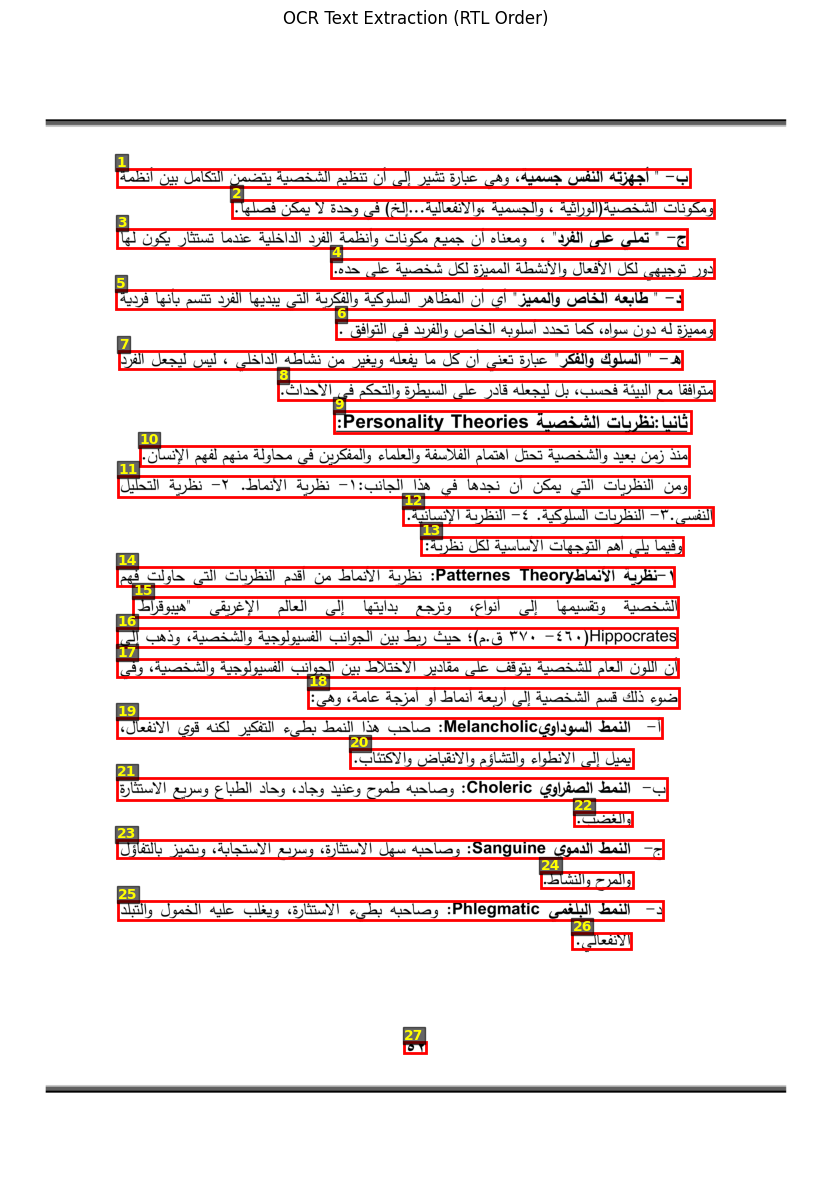

Processing Images: 100%|██████████| 1/1 [00:51<00:00, 51.09s/it]


In [50]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# --- Helper: RTL sorting function ---
def sort_bboxes_rtl(bboxes, y_threshold=20):
    """
    Sort bounding boxes top-to-bottom, right-to-left within each line.
    Ideal for Arabic text reading order.
    """
    if not bboxes:
        return []
    
    boxes = [[b.bbox[0], b.bbox[1], b.bbox[2], b.bbox[3], b.confidence] for b in bboxes]
    boxes = sorted(boxes, key=lambda b: b[1])  # sort top-to-bottom by y1

    lines = []
    current_line = [boxes[0]]
    for b in boxes[1:]:
        if abs(b[1] - current_line[-1][1]) < y_threshold:
            current_line.append(b)
        else:
            lines.append(current_line)
            current_line = [b]
    lines.append(current_line)

    # Sort each line right-to-left
    sorted_boxes = []
    for line in lines:
        line_sorted = sorted(line, key=lambda b: b[0], reverse=True)
        sorted_boxes.extend(line_sorted)
    
    return sorted_boxes


# --- Initialize models ---
foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.65

# --- Main processing loop ---
for image in tqdm(pages, desc="Processing Images"):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]

    # Filter boxes by confidence
    filtered_boxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    # Sort in RTL order for OCR
    sorted_boxes = sort_bboxes_rtl(filtered_boxes)

    # --- Crop regions in sorted order ---
    cropped_images = []
    for (x1, y1, x2, y2, _) in sorted_boxes:
        cropped = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped)

    # --- Pass to OCR ---
    if cropped_images:
        ocr_texts = extract_text_from_image(
            images=cropped_images,
            model=model,
            processor=processor
        )

    # --- Visualize OCR output with boxes ---
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)

    for i, ((x1, y1, x2, y2, _), text) in enumerate(zip(sorted_boxes, ocr_texts), start=1):
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 6, f"{i}",
            color="yellow",
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.6, pad=1)
        )

        # Print text result in console for debug
        print(f"🟨 Box {i}: {text.strip()[:100]}")

    plt.title("OCR Text Extraction (RTL Order)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [135]:
ocr_texts

['"ب- <i>"</b> أجهزته النفس جسمية، وهي عيارة تشير إلى أن تنظيم الشخصية يتضمن التكامل بين انظمتها."',
 'مكونات الشخصية (الوراثية ، والجسمية <b>،والإنفعالالية</b><i>.</i>) في وحدة لا يمكن فصلها...إلخ) فى ...وقد اكتشفت أنني أملك شخصيتي الخاصة بشكل ملحوظ .',
 '"جه- " تملئي على الفرد"، ومعناه أن جميع مكونات وأنظمة <b>الفرد</b> الداخلية عندما ستثارة يكون لهاها".',
 'دور توجيهي لكل الأفعال والأنشطة المميزة <b>لكل</b> شخصية على حده..',
 '- "طالبه الخاص والمميز" أي أن المظاهر السلوكية والفكرية التي يبديها الفرد تتسم بأنّها فردية <b>–</b></p><br/> "[ غير واضح ] طابعته الخاصة بالمتميز".',
 'وتميزة له دون سواه، كما تحدد أسلوبته الخاص والفريد في التوافق . <b>.</b></p><br/>',
 '"السولوك والفكر": عبارة تغني أن كل ما يفعله ويغير من نشاطه الداخلي ، ليس ليجعل الفرد <b>هو</b></p><br>" هدّا " السلوك و الفكر".',
 'متواققا مع البيئة فحسب، بل ليجعله قادر على السيطرة والتحكم في الأحداث..',
 'Personality Theories <b>:نظام</b> نظرات الشخصية ثانيا: : غير واضحة)',
 'ومنذ <i>بعيد</i></p><br/>الشخصية تحتل اهتمام ال

## Page reconstruction

In [136]:
from bs4 import BeautifulSoup
def reconstruct_pages(html_content):
    reconstructed_pages = []
    for content in html_content:
        soup = BeautifulSoup(content, "html.parser")
        plain_text = soup.get_text(separator="\n")
        reconstructed_pages.append(plain_text)
    return reconstructed_pages
reconstructed_texts = reconstruct_pages(ocr_texts)


In [137]:
reconstructed_texts

['"ب- \n"\n أجهزته النفس جسمية، وهي عيارة تشير إلى أن تنظيم الشخصية يتضمن التكامل بين انظمتها."',
 'مكونات الشخصية (الوراثية ، والجسمية \n،والإنفعالالية\n.\n) في وحدة لا يمكن فصلها...إلخ) فى ...وقد اكتشفت أنني أملك شخصيتي الخاصة بشكل ملحوظ .',
 '"جه- " تملئي على الفرد"، ومعناه أن جميع مكونات وأنظمة \nالفرد\n الداخلية عندما ستثارة يكون لهاها".',
 'دور توجيهي لكل الأفعال والأنشطة المميزة \nلكل\n شخصية على حده..',
 '- "طالبه الخاص والمميز" أي أن المظاهر السلوكية والفكرية التي يبديها الفرد تتسم بأنّها فردية \n–\n "[ غير واضح ] طابعته الخاصة بالمتميز".',
 'وتميزة له دون سواه، كما تحدد أسلوبته الخاص والفريد في التوافق . \n.',
 '"السولوك والفكر": عبارة تغني أن كل ما يفعله ويغير من نشاطه الداخلي ، ليس ليجعل الفرد \nهو\n" هدّا " السلوك و الفكر".',
 'متواققا مع البيئة فحسب، بل ليجعله قادر على السيطرة والتحكم في الأحداث..',
 'Personality Theories \n:نظام\n نظرات الشخصية ثانيا: : غير واضحة)',
 'ومنذ \nبعيد\nالشخصية تحتل اهتمام الفلاسفة والعلماء والمفكرين في محاولة منهم لفهم الإنسان.',
 'ومن النظري

## Evualuate

In [138]:
gt_paths="/Users/maryamsaad/Documents/grad_data/ground_truth_files/fast_test_clean.json"
with open(gt_paths, 'r', encoding='utf-8') as f:
    ground_truth_data = json.load(f)
ground_truth_data

{'1': 'ب- " أجهزته النفس جسمية، وهي عبارة تشير إلى أن تنظيم الشخصية يتضمن التكامل بي ن أنظمة \nومكونات الشخصية(الوراثية ،  و الجسمية ،والانفعالية...إلخ) في وحدة لا يمكن فصلها. \nج- " تملي على الفرد"  اهل نوكي راثتست امدنع ةيلخادلا درفلا ةمظنأو تانوكم عيمج نأ هانعمو  ،\nدور توجيهي لكل الأفعال والأنشطة المميزة لكل شخصية على حد ه. \n د- " طابعه الخاص والمميز" أي أن المظاهر السلوكية والفكرية التي يبديها الفرد تتسم بأنها فردية \nومميزة له  امك ،هاوس نودتحدد أسلوبه الخاص و الفريد في التوافق . \n ه- " السلوك والفكر" عبارة تعني أن كل ما يفعله ويغير من نشاطه الداخلي ، ليس ليجعل الفرد \nمتوافقا مع البيئة فحسب، بل ليجعله قادر على السيطرة والتحكم في الأحداث.  \nثانيا:نظريات الشخصيةPersonality Theories  : \nمنذ زمن بعيد والشخصية تحتل اهتمام الفلاسفة والعلماء والمفكرين في محاولة منهم لفهم الإنسان.  \nومن النظريات التي يمكن أن نجدها في هذا الجانب:1- نظرية الأنماط2- نظرية التحليل \nالنفسى.3- النظريات السلوكية4- النظرية الإنسانية. \n وفيما يلي أهم التوجهات الأساسية لكل نظرية: \n6-نظرية الأنماط Patterne

In [139]:
for page_text in ground_truth_data:
    ground_truth_data[page_text] = ground_truth_data[page_text].replace('\n', '').strip()
    ground_truth_data[page_text] = re.sub(r'[^\w\s\u0600-\u06FF.,؛،؟!-]', ' ', ground_truth_data[page_text])
print(ground_truth_data)
cleaned_gt = reconstruct_pages(list(ground_truth_data.values()))

{'1': 'ب-   أجهزته النفس جسمية، وهي عبارة تشير إلى أن تنظيم الشخصية يتضمن التكامل بي ن أنظمة ومكونات الشخصية الوراثية ،  و الجسمية ،والانفعالية...إلخ  في وحدة لا يمكن فصلها. ج-   تملي على الفرد   اهل نوكي راثتست امدنع ةيلخادلا درفلا ةمظنأو تانوكم عيمج نأ هانعمو  ،دور توجيهي لكل الأفعال والأنشطة المميزة لكل شخصية على حد ه.  د-   طابعه الخاص والمميز  أي أن المظاهر السلوكية والفكرية التي يبديها الفرد تتسم بأنها فردية ومميزة له  امك ،هاوس نودتحدد أسلوبه الخاص و الفريد في التوافق .  ه-   السلوك والفكر  عبارة تعني أن كل ما يفعله ويغير من نشاطه الداخلي ، ليس ليجعل الفرد متوافقا مع البيئة فحسب، بل ليجعله قادر على السيطرة والتحكم في الأحداث.  ثانيا نظريات الشخصيةPersonality Theories    منذ زمن بعيد والشخصية تحتل اهتمام الفلاسفة والعلماء والمفكرين في محاولة منهم لفهم الإنسان.  ومن النظريات التي يمكن أن نجدها في هذا الجانب 1- نظرية الأنماط2- نظرية التحليل النفسى.3- النظريات السلوكية4- النظرية الإنسانية.  وفيما يلي أهم التوجهات الأساسية لكل نظرية  6-نظرية الأنماط Patternes Theory  نظرية الأنماط من

In [140]:
cleaned_gt= cleaned_gt[0]

In [141]:
print(cleaned_gt)

ب-   أجهزته النفس جسمية، وهي عبارة تشير إلى أن تنظيم الشخصية يتضمن التكامل بي ن أنظمة ومكونات الشخصية الوراثية ،  و الجسمية ،والانفعالية...إلخ  في وحدة لا يمكن فصلها. ج-   تملي على الفرد   اهل نوكي راثتست امدنع ةيلخادلا درفلا ةمظنأو تانوكم عيمج نأ هانعمو  ،دور توجيهي لكل الأفعال والأنشطة المميزة لكل شخصية على حد ه.  د-   طابعه الخاص والمميز  أي أن المظاهر السلوكية والفكرية التي يبديها الفرد تتسم بأنها فردية ومميزة له  امك ،هاوس نودتحدد أسلوبه الخاص و الفريد في التوافق .  ه-   السلوك والفكر  عبارة تعني أن كل ما يفعله ويغير من نشاطه الداخلي ، ليس ليجعل الفرد متوافقا مع البيئة فحسب، بل ليجعله قادر على السيطرة والتحكم في الأحداث.  ثانيا نظريات الشخصيةPersonality Theories    منذ زمن بعيد والشخصية تحتل اهتمام الفلاسفة والعلماء والمفكرين في محاولة منهم لفهم الإنسان.  ومن النظريات التي يمكن أن نجدها في هذا الجانب 1- نظرية الأنماط2- نظرية التحليل النفسى.3- النظريات السلوكية4- النظرية الإنسانية.  وفيما يلي أهم التوجهات الأساسية لكل نظرية  6-نظرية الأنماط Patternes Theory  نظرية الأنماط من أقدمال

In [142]:
import re
!pip install arabic-reshaper
import arabic_reshaper


def normalize_arabic(text):
    text = re.sub(r'[\u064B-\u0652]', '', text)
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'[يى]', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'ـ', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

gt_normalized = normalize_arabic(cleaned_gt)
reconstructed_normalized = [normalize_arabic(text) for text in reconstructed_texts]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [143]:
reconstructed_normalized 
page_1 = ''
for page in reversed(reconstructed_normalized):
    page_1 += page
page_1


'و ي اردت ان تكتب لك بعض الاشياء، لكنك لم تحركا حتي الان! انت مهتم؟ انا هنا لمساعدتك في كل شيء تحتاج الي. . ابدل النص ب"الخط". : نحن جميعا يحبون البقاء علي قيد الحياه وراء الحجر الصحي الذي كننا فيه بسبب COVID-19. .اذا كنت متضررا من هذا الجوع او هذه المخاطر الصحيه... :)الانفعالي .Phlegmatic – النمط البلغمي : وصاحبه بطيء الاستثاره، ويغلب عليه الخمول والتبلدوالمرح والنشاط.وصاحب سهل الاستثاره، و سريع الاستجابه ، وبتمييز بالتفاصيل: Sanguine – النمط الدموي ج)وغضب .ب– النمط الصفراوي Choleric : وصاحبه طموح وعنيد وجاد، واحد الطباع وسيريع الاستثارهيميل الي الانطواء والتشاؤم والانقباض والاكتئاب .- النمط السوداوي : Melancholic، صاحب هذا النيفاط يعطي التفكير لكنه قوي الانفعال，:Melanchoicانيحولت ناموسها الي ملءه من الامل والرضا في الحياه المظلمه التي تمر بها. انا اشعر بالانضباط الذي يتمتع به الناس الذين هاجروا للعيش علي الارض. : - اكتشافات علميه: [غير واضحه]وهو ذلك قسم الشخصيه الي اربعه انماط او امزجه عامه، وهي: الضوء ذلك قسمه) الشخصيهيه الي اربعه وانمطا او امازيج عاما ، وهيا :وان اللون العام للشخصي

In [144]:
def extract_errors(ground_truth_data, reconstructed_texts):
    errors = []
    mean_wer = 0
    mean_cer = 0
    for i, page_text in enumerate(reconstructed_texts):
        gt_text = ground_truth_data[i]
        wer_score = wer(gt_text, page_text) 
        cer_score = cer(gt_text, page_text) 
        errors.append({
            "page": i + 1,
            "wer": round(wer_score*100, 2),
            "cer": round(cer_score*100, 2)
        })
        mean_wer += wer_score
        mean_cer += cer_score
    mean_wer /= len(reconstructed_texts)
    mean_cer /= len(reconstructed_texts)
    errors.append({
        "page": "mean",
        "wer": round(mean_wer*100, 2),
        "cer": round(mean_cer*100, 2)
    })
    return errors

In [145]:
gt_normalized

'ب- اجهزته النفس جسميه، وهي عباره تشير الي ان تنظيم الشخصيه يتضمن التكامل بي ن انظمه ومكونات الشخصيه الوراثيه ، و الجسميه ،والانفعاليه...الخ في وحده لا يمكن فصلها. ج- تملي علي الفرد اهل نوكي راثتست امدنع هيلخادلا درفلا همظناو تانوكم عيمج نا هانعمو ،دور توجيهي لكل الافعال والانشطه المميزه لكل شخصيه علي حد ه. د- طابعه الخاص والمميز اي ان المظاهر السلوكيه والفكريه التي يبديها الفرد تتسم بانها فرديه ومميزه له امك ،هاوس نودتحدد اسلوبه الخاص و الفريد في التوافق . ه- السلوك والفكر عباره تعني ان كل ما يفعله ويغير من نشاطه الداخلي ، ليس ليجعل الفرد متوافقا مع البيئه فحسب، بل ليجعله قادر علي السيطره والتحكم في الاحداث. ثانيا نظريات الشخصيهPersonality Theories منذ زمن بعيد والشخصيه تحتل اهتمام الفلاسفه والعلماء والمفكرين في محاوله منهم لفهم الانسان. ومن النظريات التي يمكن ان نجدها في هذا الجانب 1- نظريه الانماط2- نظريه التحليل النفسي.3- النظريات السلوكيه4- النظريه الانسانيه. وفيما يلي اهم التوجهات الاساسيه لكل نظريه 6-نظريه الانماط Patternes Theory نظريه الانماط من اقدمالنظريات التي حاولت فهم الش

In [146]:
page_1

'و ي اردت ان تكتب لك بعض الاشياء، لكنك لم تحركا حتي الان! انت مهتم؟ انا هنا لمساعدتك في كل شيء تحتاج الي. . ابدل النص ب"الخط". : نحن جميعا يحبون البقاء علي قيد الحياه وراء الحجر الصحي الذي كننا فيه بسبب COVID-19. .اذا كنت متضررا من هذا الجوع او هذه المخاطر الصحيه... :)الانفعالي .Phlegmatic – النمط البلغمي : وصاحبه بطيء الاستثاره، ويغلب عليه الخمول والتبلدوالمرح والنشاط.وصاحب سهل الاستثاره، و سريع الاستجابه ، وبتمييز بالتفاصيل: Sanguine – النمط الدموي ج)وغضب .ب– النمط الصفراوي Choleric : وصاحبه طموح وعنيد وجاد، واحد الطباع وسيريع الاستثارهيميل الي الانطواء والتشاؤم والانقباض والاكتئاب .- النمط السوداوي : Melancholic، صاحب هذا النيفاط يعطي التفكير لكنه قوي الانفعال，:Melanchoicانيحولت ناموسها الي ملءه من الامل والرضا في الحياه المظلمه التي تمر بها. انا اشعر بالانضباط الذي يتمتع به الناس الذين هاجروا للعيش علي الارض. : - اكتشافات علميه: [غير واضحه]وهو ذلك قسم الشخصيه الي اربعه انماط او امزجه عامه، وهي: الضوء ذلك قسمه) الشخصيهيه الي اربعه وانمطا او امازيج عاما ، وهيا :وان اللون العام للشخصي

In [147]:
results = extract_errors([gt_normalized], [page_1])
for r in results:
    print(f"Page {r['page']}: WER={r['wer']}%, CER={r['cer']}%")

Page 1: WER=187.59%, CER=137.96%
Page mean: WER=187.59%, CER=137.96%
